#### import library

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!wget https://github.com/thushv89/attention_keras/blob/master/src/layers/attention.py

--2022-01-31 10:50:31--  https://github.com/thushv89/attention_keras/blob/master/src/layers/attention.py
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘attention.py’

attention.py            [ <=>                ] 219.28K  --.-KB/s    in 0.1s    

2022-01-31 10:50:32 (2.10 MB/s) - ‘attention.py’ saved [224543]



In [ ]:
%tensorflow_version 1.15

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.15`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.


In [ ]:
import tensorflow as tf
print(tf.__version__)

1.15.2


In [ ]:
import numpy as np
import pandas as pd 
import re
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import warnings
#from attention import AttentionLayer
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

Using TensorFlow backend.


#### load dataset

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/PROJECT/pokok-perkara-data.csv')
del df['Unnamed: 0']
df.head()

,Pokok Perkara,Pokok Perkara Summaries
0,"penggugat telah mengajukan gugatan di depan persidangan pengadilan,hubungan industrial pada pengadilan negeri ternate dan memohon kepada,pengadilan untuk memberikan putusan sebagai berikut: dalam ...",Termohon kasasi/Penggugat mengajukan gugatan di Pengadilan Hubungan Industrial pada Pengadilan Negeri Ternate atas adanya Pemutusan Hubungan Kerja (PHK) oleh Pemohon Kasasi/Tergugat. Termohon kasa...
1,"penggugat telah mengajukan gugatan di depan persidangan pengadilan,hubungan industrial pada pengadilan negeri palembang dan memohon kepada pengadilan untuk memberikan putusan sebagai berikut:,dala...",Termohon Kasasi/Penggugat mengajukan gugatan di Pengadilan Hubungan Industrial pada Pengadilan Negeri Palembang atas adanya Pemutusan Hubungan Kerja (PHK) oleh Pemohon Kasasi/Tergugat. Termohon Ka...
2,"menyatakan menerima dan mengabulkan dalil-dalil gugatan penggugat untuk seluruhnya;,menyatakan untuk segera menjatuhkan putusan sela, dan memutuskan terbih dahulu tuntutan dalam provisi ini yang a...",Pemohon kasasi/Penggugat mengajukan gugatan di Pengadilan Hubungan Industrial pada Pengadilan Negeri Bandung atas adanya perselisihan hak. Namun Tergugat tidak pernah hadir dalam persidangan sehin...
3,"hubungan industrial pada pengadilan negeri medan dan memohon kepada,pengadilan untuk memberikan putusan sebagai berikut:,mengabulkan gugatan penggugat untuk seluruhnya;,menyatakan dan menetapkan h...",Termohon kasasi/Penggugat mengajukan gugatan di Pengadilan Hubungan Industrial pada Pengadilan Negeri Medan pada intinya antara lain: Menyatakan dan menetapkan hubungan kerja antara Penggugat deng...
4,"penggugat telah mengajukan gugatan di depan persidangan pengadilan,hubungan industrial pada pengadilan negeri jakarta pusat dan memohon,kepada pengadilan untuk memberikan putusan sebagai berikut: ...",Pemohon kasasi/Penggugat mengajukan gugatan di Pengadilan Hubungan Industrial pada Pengadilan Negeri Jakarta Pusat yang pada intinya memohon kepada Pengadilan untuk memberikan putusan antara lain:...


In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

#### text cleaning

____________________________________________________
Membersihkan data dari puctuation (tanda hubung), angka, link url, kata kata yang dinilai tidak penting (stpwords), serta mengubah huruf besar menjadi huruf kecil 

In [ ]:
stop_words = set(stopwords.words('indonesian')) 

def text_cleaner(text, num):
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    #newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    newString = re.sub('[m]{2,}', 'mm', newString)
    
    if(num==0):
        tokens = [w for w in newString.split() if not w in stop_words]
    else:
        tokens=newString.split()
    
    long_words=[]
    for i in tokens:
        if len(i)>1:                                                 
            long_words.append(i)   
    return (" ".join(long_words)).strip()

In [ ]:
cleaned_text = []
for t in df['Pokok Perkara']:
    cleaned_text.append(text_cleaner(t,0)) 

In [ ]:
cleaned_text[:5]

['penggugat mengajukan gugatan persidangan pengadilan hubungan industrial pengadilan negeri ternate memohon pengadilan putusan provisi mengabulkan permohonan provisi penggugat menghukum tergugat membayar biaya transportasi akomodasi penggugat proses pengajuan gugatan pemutusan hubungan kerja pengadilan hubungan industrial pengadilan negeri ternate rp persidangan rp putusan dibacakan persidangan pokok perkara menerima gugatan penggugat pemutusan hubungan kerja tergugat penggugat tanggal desember batal hukum tergugat perbuatan bertentangan undang undang nomor ketenagakerjaan hubungan kerja penggugat tergugat putus pemutusan hubungan kerja tergugat terhitung putusan kekuatan hukum menghukum tergugat membayar pesangon kompensasi pkb rp rp menghukum tergugat membayar upah tunjangan penggugat proses penyelesaian tanggal januari putusan pengadilan berkekuatan hukum rp bulannya menghukum tergugat membayar biaya transportasi akomodasi penggugat proses pengajuan gugatan pemutusan hubungan kerja 

In [ ]:
cleaned_text_summaries = []
for t in df['Pokok Perkara Summaries']:
    cleaned_text_summaries.append(text_cleaner(t,1)) 

In [ ]:
cleaned_text_summaries[:5]

['termohon kasasi penggugat mengajukan gugatan di pengadilan hubungan industrial pada pengadilan negeri ternate atas adanya pemutusan hubungan kerja oleh pemohon kasasi tergugat termohon kasasi penggugat merasa pemutusan hubungan kerja yang dilakukan oleh pemohon kasasi tergugat bertentangan dengan undang undang nomor tahun tentang ketenagakerjaan oleh karena itu pada intinya gugatan diajukan agar pemohon kasasi tergugat membayar pesangon dan kompensasi sebesar pkb yakni bulan rp rp selain itu juga membayar upah dan tunjangan penggugat selama proses penyelesaian yakni tanggal januari sampai ada putusan pengadilan yang berkekuatan hukum tetap sebesar rp untuk setiap bulannya pengadilan hubungan industrial pada pengadilan negeri ternate telah menjatuhkan putusan nomor pdt sus phi pn tte tanggal november yang amarnya menolak provisi untuk seluruhnya serta mengabulkan gugatan penggugat untuk sebagian selain itu juga menghukum tergugat untuk membayar kepada penggugat uang kompensasi pemutus

In [ ]:
df['Cleaned Pokok Perkara']=cleaned_text
df['cleaned Pokok Perkara Summary']=cleaned_text_summaries

In [ ]:
df.head()

,Pokok Perkara,Pokok Perkara Summaries,Cleaned Pokok Perkara,cleaned Pokok Perkara Summary
0,"penggugat telah mengajukan gugatan di depan persidangan pengadilan,hubungan industrial pada pengadilan negeri ternate dan memohon kepada,pengadilan untuk memberikan putusan sebagai berikut: dalam ...",Termohon kasasi/Penggugat mengajukan gugatan di Pengadilan Hubungan Industrial pada Pengadilan Negeri Ternate atas adanya Pemutusan Hubungan Kerja (PHK) oleh Pemohon Kasasi/Tergugat. Termohon kasa...,penggugat mengajukan gugatan persidangan pengadilan hubungan industrial pengadilan negeri ternate memohon pengadilan putusan provisi mengabulkan permohonan provisi penggugat menghukum tergugat mem...,termohon kasasi penggugat mengajukan gugatan di pengadilan hubungan industrial pada pengadilan negeri ternate atas adanya pemutusan hubungan kerja oleh pemohon kasasi tergugat termohon kasasi peng...
1,"penggugat telah mengajukan gugatan di depan persidangan pengadilan,hubungan industrial pada pengadilan negeri palembang dan memohon kepada pengadilan untuk memberikan putusan sebagai berikut:,dala...",Termohon Kasasi/Penggugat mengajukan gugatan di Pengadilan Hubungan Industrial pada Pengadilan Negeri Palembang atas adanya Pemutusan Hubungan Kerja (PHK) oleh Pemohon Kasasi/Tergugat. Termohon Ka...,penggugat mengajukan gugatan persidangan pengadilan hubungan industrial pengadilan negeri palembang memohon pengadilan putusan pokok perkara mengabulkan gugatan penggugat hubungan kerja penggugat ...,termohon kasasi penggugat mengajukan gugatan di pengadilan hubungan industrial pada pengadilan negeri palembang atas adanya pemutusan hubungan kerja oleh pemohon kasasi tergugat termohon kasasi pe...
2,"menyatakan menerima dan mengabulkan dalil-dalil gugatan penggugat untuk seluruhnya;,menyatakan untuk segera menjatuhkan putusan sela, dan memutuskan terbih dahulu tuntutan dalam provisi ini yang a...",Pemohon kasasi/Penggugat mengajukan gugatan di Pengadilan Hubungan Industrial pada Pengadilan Negeri Bandung atas adanya perselisihan hak. Namun Tergugat tidak pernah hadir dalam persidangan sehin...,menerima mengabulkan dalil dalil gugatan penggugat menjatuhkan putusan memutuskan terbih tuntutan provisi gugatan penggugat memerintahkan menghukum tergugat membayarkan hak hak penggugat diterima ...,pemohon kasasi penggugat mengajukan gugatan di pengadilan hubungan industrial pada pengadilan negeri bandung atas adanya perselisihan hak namun tergugat tidak pernah hadir dalam persidangan sehing...
3,"hubungan industrial pada pengadilan negeri medan dan memohon kepada,pengadilan untuk memberikan putusan sebagai berikut:,mengabulkan gugatan penggugat untuk seluruhnya;,menyatakan dan menetapkan h...",Termohon kasasi/Penggugat mengajukan gugatan di Pengadilan Hubungan Industrial pada Pengadilan Negeri Medan pada intinya antara lain: Menyatakan dan menetapkan hubungan kerja antara Penggugat deng...,hubungan industrial pengadilan negeri medan memohon pengadilan putusan mengabulkan gugatan penggugat menetapkan hubungan kerja penggugat tergugat perjanjian kerja putusnya hubungan kerja penggugat...,termohon kasasi penggugat mengajukan gugatan di pengadilan hubungan industrial pada pengadilan negeri medan pada intinya antara lain menyatakan dan menetapkan hubungan kerja antara penggugat denga...
4,"penggugat telah mengajukan gugatan di depan persidangan pengadilan,hubungan industrial pada pengadilan negeri jakarta pusat dan memohon,kepada pengadilan untuk memberikan putusan sebagai berikut: ...",Pemohon kasasi/Penggugat mengajukan gugatan di Pengadilan Hubungan Industrial pada Pengadilan Negeri Jakarta Pusat yang pada intinya memohon kepada Pengadilan untuk memberikan putusan antara lain:...,penggugat mengajukan gugatan persidangan pengadilan hubungan industrial pengadilan negeri jakarta pusat memohon pengadilan putusan provisi mengabulkan permohonan provisi penggugat menghukum tergug...,pemohon kasasi penggugat mengajukan gugatan di pengadilan hubungan industrial pada pengad

In [ ]:
del df['Pokok Perkara']
del df['Pokok Perkara Summaries']

In [ ]:
df.head()

,Cleaned Pokok Perkara,cleaned Pokok Perkara Summary
0,penggugat mengajukan gugatan persidangan pengadilan hubungan industrial pengadilan negeri ternate memohon pengadilan putusan provisi mengabulkan permohonan provisi penggugat menghukum tergugat mem...,termohon kasasi penggugat mengajukan gugatan di pengadilan hubungan industrial pada pengadilan negeri ternate atas adanya pemutusan hubungan kerja oleh pemohon kasasi tergugat termohon kasasi peng...
1,penggugat mengajukan gugatan persidangan pengadilan hubungan industrial pengadilan negeri palembang memohon pengadilan putusan pokok perkara mengabulkan gugatan penggugat hubungan kerja penggugat ...,termohon kasasi penggugat mengajukan gugatan di pengadilan hubungan industrial pada pengadilan negeri palembang atas adanya pemutusan hubungan kerja oleh pemohon kasasi tergugat termohon kasasi pe...
2,menerima mengabulkan dalil dalil gugatan penggugat menjatuhkan putusan memutuskan terbih tuntutan provisi gugatan penggugat memerintahkan menghukum tergugat membayarkan hak hak penggugat diterima ...,pemohon kasasi penggugat mengajukan gugatan di pengadilan hubungan industrial pada pengadilan negeri bandung atas adanya perselisihan hak namun tergugat tidak pernah hadir dalam persidangan sehing...
3,hubungan industrial pengadilan negeri medan memohon pengadilan putusan mengabulkan gugatan penggugat menetapkan hubungan kerja penggugat tergugat perjanjian kerja putusnya hubungan kerja penggugat...,termohon kasasi penggugat mengajukan gugatan di pengadilan hubungan industrial pada pengadilan negeri medan pada intinya antara lain menyatakan dan menetapkan hubungan kerja antara penggugat denga...
4,penggugat mengajukan gugatan persidangan pengadilan hubungan industrial pengadilan negeri jakarta pusat memohon pengadilan putusan provisi mengabulkan permohonan provisi penggugat menghukum tergug...,pemohon kasasi penggugat mengajukan gugatan di pengadilan hubungan industrial pada pengadilan negeri jakarta pusat yang pada intinya memohon kepada pengadilan untuk memberikan putusan antara lain ...


In [ ]:
df.tail()

,Cleaned Pokok Perkara,cleaned Pokok Perkara Summary
45,hubungan industrial pengadilan negeri serang memohon pengadilan putusan menerima mengabulkan gugatan penggugat pemutusan hubungan kerja tergugat penggugat tanggal desember sah bertentangan aturan ...,permohonan ini berawal dari adanya gugatan dari termohon kasasi yang dahulu sebagai penggugat ke pengadilan hubungan industrial pada pengadilan negeri serang karena adanya pemutusan hubungan kerja...
46,pengadilan hubungan industrial pengadilan negeri surabaya memohon pengadilan putusan primair menerima mengabulkan gugatan penggugat pemutusan hubungan kerja tergugat penggugat sah bertentangan atu...,pemohon kasasi dahulu penggugat mengajukan gugatan ke pengadilan hubungan industrial pada pengadilan negeri surabaya agar pemutusan hubungan kerja yang dilakukan termohon kasasi dahulu tergugat ti...
47,pengadilan putusan provisi mengabulkan permohonan provisi penggugat sah berharga sita jaminan menghukum tergugat membayar hak hak penggugat bersifat normatif sengaja dibayarkan gaji dibayarkan rp ...,termohon kasasi mengajukan gugatan ke pengadilan hubungan industrial pada pengadilan ternate sebagai penggugat yang pada intinya meminta pemohon kasasi sebagai tergugat untuk membayarkan gaji peng...
48,penggugat mengajukan gugatan persidangan pengadilan hubungan industrial pengadilan negeri jakarta pusat memohon pengadilan putusan primair menerima mengabulkan gugatan penggugat tergugat pelanggar...,pemohon kasasi mengajukan gugatan di pengadilan hubungan industrial pada pengadilan negeri jakarta pusat pemohon kasasi yang sebelumnya merupakan penggugat menyatakan bahwa termohon kasasi yang se...
49,penggugat mengajukan gugatan persidangan pengadilan hubungan industrial pengadilan negeri medan memohon pengadilan putusan pokok perkara menerima mengabulkan gugatan penggugat menghukum tergugat m...,pemohon kasasi penggugat mengajukan gugatan di pengadilan hubungan industrial pada pengadilan negeri medan atas adanya pemutusan hubungan kerja oleh termohon kasasi tergugat pemohon kasasi penggug...


#### distribution on word

____________________________
Melihat panjang kata maksimal pada masing-masing kolom untuk menentukan jumlah maksimal kata (max_len) yang akan digunakan pada proses selanjutnya

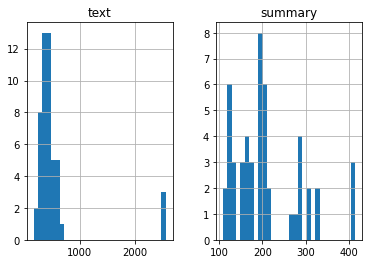

In [ ]:
import matplotlib.pyplot as plt

text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in df['Cleaned Pokok Perkara']:
      text_word_count.append(len(i.split()))

for i in df['cleaned Pokok Perkara Summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})

length_df.hist(bins = 30)
plt.show()

In [ ]:
count = 0
for i in df['cleaned Pokok Perkara Summary']:
    if(len(i.split())<=400):
        count += 1
print(count/len(df['cleaned Pokok Perkara Summary']))

0.94


In [ ]:
count = 0
for i in df['Cleaned Pokok Perkara']:
    if(len(i.split())<=800):
        count += 1
print(count/len(df['Cleaned Pokok Perkara']))

0.94


In [ ]:
max_text_len=800
max_summary_len=400

In [ ]:
cleaned_text =np.array(df['Cleaned Pokok Perkara'])
cleaned_summary=np.array(df['cleaned Pokok Perkara Summary'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])
        
df=pd.DataFrame({'text':short_text,'summary':short_summary})

In [ ]:
df['summary'] = df['summary'].apply(lambda x : 'sostok '+ x + ' eostok')

In [ ]:
for i in range(5):
    print("Review:",df['text'][i])
    print("Summary:",df['summary'][i])
    print("\n")

Review: penggugat mengajukan gugatan persidangan pengadilan hubungan industrial pengadilan negeri ternate memohon pengadilan putusan provisi mengabulkan permohonan provisi penggugat menghukum tergugat membayar biaya transportasi akomodasi penggugat proses pengajuan gugatan pemutusan hubungan kerja pengadilan hubungan industrial pengadilan negeri ternate rp persidangan rp putusan dibacakan persidangan pokok perkara menerima gugatan penggugat pemutusan hubungan kerja tergugat penggugat tanggal desember batal hukum tergugat perbuatan bertentangan undang undang nomor ketenagakerjaan hubungan kerja penggugat tergugat putus pemutusan hubungan kerja tergugat terhitung putusan kekuatan hukum menghukum tergugat membayar pesangon kompensasi pkb rp rp menghukum tergugat membayar upah tunjangan penggugat proses penyelesaian tanggal januari putusan pengadilan berkekuatan hukum rp bulannya menghukum tergugat membayar biaya transportasi akomodasi penggugat proses pengajuan gugatan pemutusan hubungan 

#### splitting data
________________________________________________________________
Data dibagi menjadi dua bagian train dan test, dengan proporsi masing-masing train sebesar 80% dan test sebesar 20%

In [ ]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(np.array(df['text']),np.array(df['summary']),test_size=0.2,random_state=0) 

#### tokenisasi
__________________________________________________________________________
Tokenisasi adalah proses untuk membagi teks yang dapat berupa kalimat, paragraf atau dokumen, menjadi token-token/bagian-bagian tertentu. Karena sebelumnya pembagian data sudah dilakukan maka proses tokenisasi dibagi menjadi dua bagian, tokenisasi data train dan data test

##### train tokenize

In [ ]:
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))

In [ ]:
thresh=4

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 50.76400679117148
Total Coverage of rare words: 3.6104879416713405


In [ ]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1
x_voc

291

##### test tokenize

In [ ]:
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_tr))

In [ ]:
thresh=6

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 58.02197802197803
Total Coverage of rare words: 8.209278797514092


In [ ]:
#prepare a tokenizer for summaries on training data
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1

In [ ]:
y_tokenizer.word_counts['sostok'],len(y_tr)

(35, 35)

In [ ]:
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

In [ ]:
ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

#### build model

##### build attention layer
__________________________________________________________
attention layer didapatkan dari link github (https://github.com/thushv89/attention_keras) dan dapat dijalankan pada versi Tensorflow 1.14 dan 1.15

In [ ]:
import os
from tensorflow.python.keras.layers import Layer
from tensorflow.python.keras import backend as K


class AttentionLayer(Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs, verbose=False):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs
        if verbose:
            print('encoder_out_seq>', encoder_out_seq.shape)
            print('decoder_out_seq>', decoder_out_seq.shape)

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state
            inputs: (batchsize * 1 * de_in_dim)
            states: (batchsize * 1 * de_latent_dim)
            """

            assert_msg = "States must be an iterable. Got {} of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            """ Some parameters required for shaping tensors"""
            en_seq_len, en_hidden = encoder_out_seq.shape[1], encoder_out_seq.shape[2]
            de_hidden = inputs.shape[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch size * en_seq_len * latent_dim
            W_a_dot_s = K.dot(encoder_out_seq, self.W_a)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim
            if verbose:
                print('Ua.h>', U_a_dot_h.shape)

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            Ws_plus_Uh = K.tanh(W_a_dot_s + U_a_dot_h)
            if verbose:
                print('Ws+Uh>', Ws_plus_Uh.shape)

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.squeeze(K.dot(Ws_plus_Uh, self.V_a), axis=-1)
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            if verbose:
                print('ei>', e_i.shape)

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """

            assert_msg = "States must be an iterable. Got {} of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            # <= batch_size, hidden_size
            c_i = K.sum(encoder_out_seq * K.expand_dims(inputs, -1), axis=1)
            if verbose:
                print('ci>', c_i.shape)
            return c_i, [c_i]

        fake_state_c = K.sum(encoder_out_seq, axis=1)
        fake_state_e = K.sum(encoder_out_seq, axis=2)  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e],
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c],
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

##### add attention layer to the model

_______________________________________________________________
Input layer berasal dari panjang maksimal kata yaitu 800. Kemudian, pada layer embedding menggunakan nilai dari panjang maksimal teks asli dan teks dari pakar dengan jumlah 800 dan 400 kata. Selanjutnya, implementasi stacked LSTM yang memiliki beberapa lapisan LSTM yang ditumpuk di atas satu sama lain dengan jumlah neuron yang didasarkan pada latent dimesi yang didefinisikan dengan angka 150. Penggunaan Layer Attention juga dilibatkan dalam pembuatan model ini untuk memaksimalkan proses encoding dan decoding pada teks. Sehingga, untuk menggabungkan kedua layer LSTM dan Attention perlu didefinisikan layer penggabungan yang dengan input yang berasal dari kedua layer tersebut. Tahap terakhir adalah pendefinisian output layer menggunakan Layer Dense dengan aktivasi softmax

In [ ]:
K.clear_session()

latent_dim = 150
embedding_dim = 400

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.1,recurrent_dropout=0.1)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.1,recurrent_dropout=0.1)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.1,recurrent_dropout=0.1)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.2,recurrent_dropout=0.1)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

# Attention layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# Concat attention input and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 800)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 800, 400)     116400      input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 800, 150), ( 330600      embedding[0][0]                  
_____________________________________________________________________________________________

#### compile model

_______________________________________________________________
compile model digunakan optimizer *rmsprop* dengan acuan loss *sparse_categorical_crossentropy* karena mampu mengubah urutan bilangan bulat menjadi bentuk one-hot vector dengan cepat. Nilai iterasi/epoch didefinisikan dengan angka 500 menggunakan callback earlystopping dengan patience 10, jadi ketika nilai loss tidak berubah hingga 10 kali maka nilai terendah terakhir yang akan digunakan.

In [ ]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=10)
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=500,callbacks=[es],batch_size=128, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 35 samples, validate on 9 samples
Epoch 1/500
35/35 [==============================] - 36s 1s/sample - loss: 5.2594 - val_loss: 4.9849
Epoch 2/500
35/35 [==============================] - 11s 325ms/sample - loss: 4.9528 - val_loss: 3.4684
Epoch 3/500
35/35 [==============================] - 11s 326ms/sample - loss: 3.2666 - val_loss: 3.0605
Epoch 4/500
35/35 [==============================] - 12s 329ms/sample - loss: 2.6497 - val_loss: 2.7130
Epoch 5/500
35/35 [==============================] - 12s 330ms/sample - loss: 2.3913 - val_loss: 2.6322
Epoch 6/500
35/35 [==============================] - 12s 329ms/sample - loss: 2.3069 - val_loss: 2.5845
Epoch 7/500
35/35 [==============================] - 11s 327ms/sample - loss: 2.2633 - val_loss: 2.5517
Epoch 8/500
35/35 [==============================] - 12s 329ms/sample - loss: 2.2327 - val_loss: 2.5275
Epoch 9/500
35/35 [===============

#### graph evaluate

___________________________________________
untuk melihat plot dari value train dan test yang telah di training sebelumnya serta untuk melihat adakah ciri fitting pada model (underfit, overfit, atau goodfit)

In [ ]:
model.save('/content/drive/MyDrive/PROJECT/model and history/model-3.h5')

In [ ]:
# menyimpan history
import json

target_dir = '/content/drive/MyDrive/PROJECT/model and history'

# simpan history model
history_dict = history.history
json.dump(history_dict, open(target_dir + '/history-3.json', 'w'))


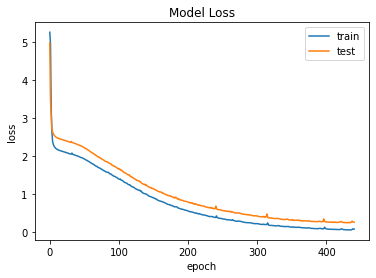

In [ ]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
pyplot.legend()
pyplot.show()

Grafik masih menunjukkan sedikit cela overfit untuk hasil splitting 80:20

#### result (summaries)

##### decode ouput

___________________________________________
karena sebelumnya input yang dimasukkan ke dalam model melalui proses encode maka untuk menampilkan hasil peringkasan output dari model yang dibangun perlu melalui proses decode

In [ ]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

In [ ]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [ ]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [ ]:
# for i in range(0,49):
#     print("Text:",seq2text(x_tr[i]))
#     print("summary:",seq2summary(y_tr[i]))
#     print("Predicted summary:",decode_sequence(x_tr[i].reshape(1,max_text_len)))
#     print("\n")


##### menampilkan hasil peringkasan (predicted summary adalah hasil peringkasan menggunakan LSTM)

In [ ]:
summary = []
predicted = []
for i in range(0,35):
    print("Text:",seq2text(x_tr[i]))
    print("summary:",seq2summary(y_tr[i]))
    print("Predicted summary:",decode_sequence(x_tr[i].reshape(1,max_text_len)))
    print("\n")
    s = seq2summary(y_tr[i])
    p = decode_sequence(x_tr[i].reshape(1,max_text_len))
    summary.append(s)
    predicted.append(p)


Text: provisi mengabulkan gugatan penggugat memerintahkan tergugat membayar upah pokok penggugat desember putusan perkara berkekuatan hukum desember rp januari putusan perkara berkekuatan hukum rp putusan dilaksanakan upaya hukum kasasi pokok perkara mengabulkan gugatan penggugat tergugat perbuatan bertentangan undang undang nomor ketenagakerjaan pemutusan hubungan kerja tergugat penggugat batal hukum surat pemutusan hubungan kerja nomor int mas sk phk hr tanggal oktober tergugat penggugat batal hukum memerintahkan tergugat mempekerjakan penggugat jabatan memulihkan membayarkan hak hak penggugat sediakala menghukum tergugat membayar upah tunjangan penggugat diterima penggugat putusan pengadilan hubungan industrial ditetapkan desember oktober tunai rp menghukum tergugat membayar uang paksa penggugat tunai rp tergugat lalai sengaja mempekerjakan penggugat putusan putusan berkekuatan hukum menghukum tergugat membayar upah proses terhitung putusan dibacakan putusan pengadilan hubungan indu

##### install rouge score library

In [ ]:
!pip install rouge-score

##### perhitungan rouge score menggunakan scorer rouge1

In [ ]:
# importing the native rouge library
from rouge_score import rouge_scorer

# a list of the hypothesis documents
hyp = summary
# a list of the references documents
ref = predicted

# make a RougeScorer object with rouge_types=['rouge1']
scorer = rouge_scorer.RougeScorer(['rouge1'])

# a dictionary that will contain the results
results = {'precision': [], 'recall': [], 'fmeasure': []}

# for each of the hypothesis and reference documents pair
for (h, r) in zip(hyp, ref):
    # computing the ROUGE
    score = scorer.score(h, r)
    # separating the measurements
    precision, recall, fmeasure = score['rouge1']
    # add them to the proper list in the dictionary
    results['precision'].append(precision)
    results['recall'].append(recall)
    results['fmeasure'].append(fmeasure)

##### result rouge score (precision, recall, and fmeasure)

In [ ]:
import pandas as pd 

data = {'precision': results['precision'], 
        'recall': results['recall'], 
        'fmeasure': results['fmeasure']} 

df = pd.DataFrame(data, columns= ['precision','recall','fmeasure'])
df

,precision,recall,fmeasure
0,1.000000,1.000000,1.000000
1,0.758065,0.550781,0.638009
2,1.000000,1.000000,1.000000
3,0.648221,0.854167,0.737079
4,0.500000,0.800000,0.615385
5,0.593939,0.942308,0.728625
6,0.817073,0.736264,0.774566
7,1.000000,0.989362,0.994652
8,1.000000,1.000000,1.000000
9,1.000000,0.989362,0.994652


##### save score to csv

In [ ]:
df.to_csv('/content/drive/MyDrive/PROJECT/rouge_score_final_20%_splitting_lstm.csv')